Modules Requirement

In [ ]:
!pip install biopython
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install scikit-learn
!pip install requests

In [ ]:
import pandas as pd
from Bio import *
from Bio.PDB import PDBList, PDBParser, PPBuilder
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
from collections import Counter
import scipy.stats as stats
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [ ]:
# !pip install biopython
# !pip install matplotlib
# !pip install numpy
# !pip install scipy
# !pip install scikit-learn

Required Functions

In [ ]:
def calculate_stddev(numbers):
    mean = sum(numbers) / len(numbers)
    sum_of_squared_diff = sum((x.real - mean) ** 2 for x in numbers)
    variance = sum_of_squared_diff / len(numbers)
    stddev = abs(variance)
    return stddev

def calc_avg(num):
    mean = sum(num)/len(num)
    return mean

def z_score(protein_seq, dft_mean, dft_std):
    dft = np.sum(
        [1 if aa in 'DE' else -1 if aa in 'RK' else 0 for aa in protein_seq])
    z = (dft - dft_mean) / dft_std
    return z

def zScore(vec1):
    zscV1 = list()
    average = calc_avg(vec1)
    stdDeviation = calculate_stddev(vec1)
    for i in range(0, len(vec1)):
        zscV1[i] = (vec1[i]-average)/(stdDeviation)
    return zscV1

def calculate_mode(numbers):
    frequency = Counter(numbers)
    max_frequency = max(frequency.values())
    modes = [num for num, freq in frequency.items() if freq == max_frequency]
    return modes

def compute_theta_ratio(metric_functions, Nsp):
    theta_ratios = []
    for theta in range(1, 6):
        N_theta = 0
        for a in range(0, len(metric_functions)):
            for n in range(1, Nsp):
                zn_a = metric_functions[a][n]
                if zn_a > theta:
                    N_theta += 1
        theta_ratio = (100 * N_theta) / (5 * (Nsp - 1))
        theta_ratios.append(theta_ratio)
    return theta_ratios

In [ ]:
data = pd.read_csv('/content/DATA.csv')
column_0_values = data.iloc[0:200, 0].tolist()
test_0_values = data.iloc[570:610, 0].tolist()
print(test_0_values)

['3ZNG', '4DUI', '4G8L', '4G8L', '4I1A', '4KVM', '4M59', '4OAV', '4OE1', '4QFV', '4YDY', '4Z68', '5CED', '5DIZ', '5EIL', '5EIL', '5GP7', '5IWW', '5LE3', '5LHD', '5MA5', '5MA5', '5MA9', '5U0K', '6C9K', '6C9K', '6C9K', '6FP8', '6FPB', '6MOG', '6MZF', '6OO5', '6OO5', '1MX4', '1SLY', '2NYJ', '2RFM', '2Y1L', '2YJY', '3J5Q']


In [ ]:
# def get_protein_fasta_sequence(pdb_id):
#     pdb_list = PDBList()
#     temp_dir = "."

#     pdb_filename = pdb_list.retrieve_pdb_file(pdb_id, pdir=temp_dir,file_format="pdb")

#     pdb_parser = PDBParser(QUIET=True)

#     structure = pdb_parser.get_structure(pdb_id, pdb_filename)
#     pp_builder = PPBuilder()

#     sequences = []
#     for model in structure:
#         for chain in model:
#             peptides = pp_builder.build_peptides(chain)
#             for peptide in peptides:
#                 sequence = str(peptide.get_sequence())
#                 sequences.append(sequence)
#     import os
#     os.remove(pdb_filename)

#     return sequences

# # pdb_id = "1ezg"
# lst=[]
# for x in column_0_values:
#   protein_sequences = get_protein_fasta_sequence(x)
#   # print(protein_sequences)
#   lst.append(protein_sequences)

# # print(lst)
# seqMatrix=[]
# for x in lst:
#   for i in x:
#     seqMatrix.append(i)
#     break

# # print(matrix)
# # print(len(seqMatrix))

Conversion of PDBID to UNIPROTID

In [ ]:
# Install necessary library
# !pip install requests

# # Import the requests module
import requests
# import json

# Function to Fetch UniProt ID from PDB ID
def fetch_uniprot_id_from_pdb(pdb_id):
    url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        try:
            # Extract UniProt ID from the JSON response
            for entity in data['rcsb_entry_container_identifiers']['polymer_entity_ids']:
                entity_url = f"https://data.rcsb.org/rest/v1/core/polymer_entity/{pdb_id}/{entity}"
                entity_response = requests.get(entity_url)
                if entity_response.status_code == 200:
                    entity_data = entity_response.json()
                    for reference in entity_data.get('rcsb_polymer_entity_container_identifiers', {}).get('uniprot_ids', []):
                        return reference
            return "notFound"
        except KeyError:
            return "Unable to extract UniProt ID"
    else:
        return f"Error fetching data: HTTP {response.status_code}"

# Replace 'YOUR_PDB_ID' with the actual PDB ID
pdb_id = '3TWQ'  # Replace with a PDB ID
uniprot_id = fetch_uniprot_id_from_pdb(pdb_id)
print("UniProt ID:", uniprot_id)

UniProt ID: Q9H2K2


Fetching Repeats and Non Repeating Unit Information from UNIPROT API using UNIPROTID


In [ ]:
# # Install necessary library
# !pip install requests

# # Import the requests module
# import requests

# Function to Fetch Data from UniProt
def fetch_uniprot_data(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.txt"
    response = requests.get(url)

    if response.status_code == 200:
        return response.text
    else:
        return f"Error fetching data: HTTP {response.status_code}"

# Function to Extract Repeat Information
def extract_repeat_info(uniprot_data):
    lines = uniprot_data.split("\n")
    repeat_info = [line for line in lines if line.startswith("FT   REPEAT")]
    return True if repeat_info else False

# Fetch and Display Repeat Information
uniprot_id = 'Q9H2K2'  # Replace with a valid UniProt ID
uniprot_data = fetch_uniprot_data(uniprot_id)
repeats = extract_repeat_info(uniprot_data)
print((repeats))
# For printing the exact repeat units INFO
# for repeat in repeats:
#     print(repeat)

True


Presence of Repeats and Non Repeats

In [ ]:
pdb = PDBList()
resultRepeatNR = []
resultantList = []
testResultantList = []
testList = []
print(column_0_values)
for x in column_0_values:
  uniprotID = fetch_uniprot_id_from_pdb(x)
  if uniprotID != "notFound":
    resultantList.append(x)
    checkFetchUNI = fetch_uniprot_data(uniprotID)
    checkRepeatFinalUNI = extract_repeat_info(checkFetchUNI)
    if checkRepeatFinalUNI:
      resultRepeatNR.append(1)
    else:
      resultRepeatNR.append(0)
  else:
    continue
  # check =
# print(resultRepeatNR)
# print(len(resultRepeatNR))

# for x in test_0_values:
#   uniprotID = fetch_uniprot_id_from_pdb(x)
#   if uniprotID != "notFound":
#     testResultantList.append(x)
#     checkFetchUNI = fetch_uniprot_data(uniprotID)
#     checkRepeatFinalUNI = extract_repeat_info(checkFetchUNI)
#     if checkRepeatFinalUNI:
#       testList.append(1)
#     else:
#       testList.append(0)
#   else:
#     continue



['3TWQ', '3Q9N', '3Q9U', '3TWR', '3TWS', '3TWS', '3TWS', '3TWT', '3TWV', '3TWX', '3TWX', '5BXU', '5ENT', '5Z2M', '1QYM', '1UOH', '2P2C', '2P2C', '2XZT', '2XZT', '3C5R', '3C5R', '3EHR', '3NOC', '3Q9N', '3TWQ', '3TWR', '3TWT', '3TWT', '3TWV', '3TWW', '3UTM', '4ATZ', '4ATZ', '4CYM', '4CZ2', '4CZ2', '4DX5', '4DX6', '4DX7', '4HLL', '4LSZ', '4LSZ', '4U8V', '4U8Y', '4U96', '5AAO', '5AAO', '5AAO', '5AAO', '5AAO', '5AAO', '5EN5', '5ENR', '5ENS', '5ENS', '5ENS', '5GIK', '5JMN', '5LW2', '5NC5', '5VHO', '5VHP', '5Z2N', '6H47', '6AUN', '1N11', '2BKG', '2DVW', '2DWZ', '2DWZ', '2J8S', '2P2C', '2P2C', '2QYJ', '2Y0B', '3AJI', '3D9H', '3EHQ', '3EHQ', '3EHR', '3IXE', '3TWV', '3TWW', '3UTM', '3V31', '3ZU7', '4B93', '4BSZ', '4CYM', '4CYM', '4CZ2', '4DRX', '4DRX', '4DX5', '4HQD', '4LNU', '4NIK', '4QQI', '4U95', '5AAO', '5AAO', '5AAO', '5EIB', '5EN5', '5ENO', '5ENP', '5ENR', '5H76', '5HKP', '5LED', '5NM5', '5NQT', '5O2S', '5O2S', '5O2S', '5O2S', '5O2T', '5VHR', '5Y4F', '5Y4F', '6CF6', '6FES', '6MOK', '6MZE',

Testing Check

In [ ]:
# for x in test_0_values:
#   uniprotID = fetch_uniprot_id_from_pdb(x)
#   if uniprotID != "notFound":
#     testResultantList.append(x)
#     checkFetchUNI = fetch_uniprot_data(uniprotID)
#     checkRepeatFinalUNI = extract_repeat_info(checkFetchUNI)
#     if checkRepeatFinalUNI:
#       testList.append(1)
#     else:
#       testList.append(0)
#   else:
#     continue

Getting sequences for the Required ones


In [ ]:
def get_protein_fasta_sequence(pdb_id):
    pdb_list = PDBList()
    temp_dir = "."

    pdb_filename = pdb_list.retrieve_pdb_file(pdb_id, pdir=temp_dir,file_format="pdb")

    pdb_parser = PDBParser(QUIET=True)

    structure = pdb_parser.get_structure(pdb_id, pdb_filename)
    pp_builder = PPBuilder()

    sequences = []
    for model in structure:
        for chain in model:
            peptides = pp_builder.build_peptides(chain)
            for peptide in peptides:
                sequence = str(peptide.get_sequence())
                sequences.append(sequence)
    import os
    os.remove(pdb_filename)

    return sequences

# pdb_id = "1ezg"
lst=[]
for x in resultantList:
  protein_sequences = get_protein_fasta_sequence(x)
  lst.append(protein_sequences)


testLst=[]
for x in test_0_values:
  protein_sequences = get_protein_fasta_sequence(x)
  testLst.append(protein_sequences)
# print(lst)

seqMatrix=[]
for x in lst:
  for i in x:
    seqMatrix.append(i)
    break

testMatrix=[]
for x in testLst:
  for i in x:
    testMatrix.append(i)
    break

# print(seqMatrix)
# print(len(seqMatrix))

Main coding

a)Mapping

In [ ]:
dicfact1 = {'A': -0.591, 'C': -1.343, 'D': 1.050, 'E': 1.375, 'F': -1.006, 'G': -0.384, 'H': 0.036, 'I': -1.29, 'K': 1.831, 'L': -1.019, 'M': -0.663, 'N': 0.945, 'P': 0.189, 'Q': 0.931, 'R': 1.538, 'S': -0.228, 'T': -0.032, 'V': -1.337, 'W': -0.595, 'Y': 0.260}


dicfact2 = {'A': -1.302, 'C': 0.465, 'D': 0.302, 'E': -1.453, 'F': -0.590, 'G': 1.652, 'H': -0.417, 'I': -0.547, 'K': -0.561, 'L': -0.987, 'M': -1.524, 'N': 0.828, 'P': 2.081, 'Q': -0.179, 'R': -0.055, 'S': 1.399, 'T': 0.326, 'V': -0.279, 'W': 0.009, 'Y': 0.830}


dicfact3 = {'A': -0.733, 'C': -0.862, 'D': -3.656, 'E': 1.477, 'F': 1.891, 'G': 1.330, 'H': -1.673, 'I': 2.131, 'K': 0.533, 'L': -1.505, 'M': 2.219, 'N': 1.299, 'P': -1.628, 'Q': -3.005, 'R': 1.502, 'S': -4.760, 'T': 2.213, 'V': -0.544, 'W': 0.672, 'Y': 3.097}


dicfact4 = {'A': 1.570, 'C': -1.020, 'D': -0.259, 'E': 0.113, 'F': -0.397, 'G': 1.045, 'H': -1.474, 'I': 0.393, 'K': -0.277, 'L': 1.266, 'M': -1.005, 'N': -0.169, 'P': 0.421, 'Q': -0.503, 'R': 0.440, 'S': 0.670, 'T': 0.908, 'V': 1.242, 'W': -2.128, 'Y': -0.838}


dicfact5 = {'A': -0.146, 'C': -0.255, 'D': -3.242, 'E': -0.837, 'F': 0.412, 'G': 2.064, 'H': -0.078, 'I': 0.816, 'K': 1.648, 'L': -0.912, 'M': 1.212, 'N': 0.933, 'P': -1.392, 'Q': -1.853, 'R': 2.897, 'S': -2.647, 'T': 1.313, 'V': -1.262, 'W': -0.184, 'Y': 1.512}

b)Storing Mapping of sequences

In [ ]:
matrix = list()
for a in range(len(seqMatrix)):
    s = seqMatrix[a]
    vec1 = list()
    vec2 = list()
    vec3 = list()
    vec4 = list()
    vec5 = list()
    for i in range(len(s)):
        vec1.append((dicfact1[s[i]]))
        vec2.append((dicfact2[s[i]]))
        vec3.append((dicfact3[s[i]]))
        vec4.append((dicfact4[s[i]]))
        vec5.append((dicfact5[s[i]]))

    res = []
    res.append(vec1)
    res.append(vec2)
    res.append(vec3)
    res.append(vec4)
    res.append(vec5)
    matrix.append(res)


testResultMatrix =list()
for a in range(len(testMatrix)):
    s = testMatrix[a]
    vec1 = list()
    vec2 = list()
    vec3 = list()
    vec4 = list()
    vec5 = list()
    for i in range(len(s)):
        vec1.append((dicfact1[s[i]]))
        vec2.append((dicfact2[s[i]]))
        vec3.append((dicfact3[s[i]]))
        vec4.append((dicfact4[s[i]]))
        vec5.append((dicfact5[s[i]]))

    res = []
    res.append(vec1)
    res.append(vec2)
    res.append(vec3)
    res.append(vec4)
    res.append(vec5)
    testResultMatrix.append(res)

# print(matrix)

C)FFT calculation
---



In [ ]:
for i in range(len(matrix)):
    for j in range(5):
        matrix[i][j] = np.fft.fft(matrix[i][j])

for i in range(len(testResultMatrix)):
    for j in range(5):
        testResultMatrix[i][j] = np.fft.fft(testResultMatrix[i][j])

D)Normalization of FFT sequence

In [ ]:
for i in range(len(matrix)):
    for j in range(5):
        lenx = len(matrix[i][j])
        for k in range(1, lenx):
            a = np.real(matrix[i][j][k])
            b = np.imag(matrix[i][j][k])
            result = np.fabs((a**2) + (b**2))
            result = result / (math.sqrt(lenx))
            result = result/2
            matrix[i][j][k-1] = result

for i in range(len(testResultMatrix)):
    for j in range(5):
        lenx = len(testResultMatrix[i][j])
        for k in range(1, lenx):
            a = np.real(testResultMatrix[i][j][k])
            b = np.imag(testResultMatrix[i][j][k])
            result = np.fabs((a**2) + (b**2))
            result = result / (math.sqrt(lenx))
            result = result/2
            testResultMatrix[i][j][k-1] = result

E)Zscore Calculation

In [ ]:
for i in range(len(matrix)):
    for j in range(5):
        matrix[i][j] = stats.zscore(matrix[i][j])

for i in range(len(matrix)):
    for j in range(5):
        lenx = len(matrix[i][j])
        for k in range(lenx):
            matrix[i][j][k] = np.real(matrix[i][j][k])


for i in range(len(testResultMatrix)):
    for j in range(5):
        testResultMatrix[i][j] = stats.zscore(matrix[i][j])

for i in range(len(testResultMatrix)):
    for j in range(5):
        lenx = len(testResultMatrix[i][j])
        for k in range(lenx):
            testResultMatrix[i][j][k] = np.real(testResultMatrix[i][j][k])

F)Max_Score Calculations

In [ ]:
maxScores = list()
for i in range(len(matrix)):
    maxi=0
    for j in range(5):
        maxi = max(maxi, max(matrix[i][j]))
    maxScores.append(abs(maxi))


testMaxScores = list()
for i in range(len(testResultMatrix)):
    maxi=0
    for j in range(5):
        maxi = max(maxi, max(testResultMatrix[i][j]))
    testMaxScores.append(abs(maxi))

print((maxScores))

[5.710989579962791, 6.474895423208634, 6.474895423208634, 6.474895423208634, 6.474895423208634, 6.7749809549384326, 6.78971345860962, 6.306443831127838, 6.306443831127838, 5.642088760323973, 5.6523591410327585, 5.771797689158149, 7.372143348808251, 7.372143348808251, 5.157089891321496, 5.157089891321496, 4.347790916535686, 4.347790916535686, 5.4372485487573226, 5.4372485487573226, 3.331412686208507, 7.270230274711963, 5.710989579962791, 6.474895423208634, 6.7749809549384326, 6.7749809549384326, 6.78971345860962, 6.452448713142489, 6.649553555822772, 4.626350681050636, 4.626350681050636, 5.005647872066974, 4.2108095908056935, 4.2108095908056935, 10.298999336862355, 10.40083475910192, 10.255717401385391, 5.5233529320986845, 5.5233529320986845, 10.319397375382637, 10.315384307451591, 10.658881300249185, 5.6523591410327585, 5.6523591410327585, 5.6523591410327585, 5.6523591410327585, 5.6523591410327585, 11.733489999300852, 10.298999336862355, 2.412951395861083, 8.502191315767002, 5.86399734

G)Thetha Ratio Calculation

In [ ]:
thetaRationsMatrix = list()
testThethaRationMatrix = list()
for i in range(len(matrix)):
    testVector = list()
    for j in range(5):
        testVector.append(matrix[i][j])
    thetaRationsMatrix.append(compute_theta_ratio(testVector, len(matrix[i][j]))[3])

for i in range(len(testResultMatrix)):
    testVector = list()
    for j in range(5):
        testVector.append(matrix[i][j])
    testThethaRationMatrix.append(compute_theta_ratio(testVector, len(matrix[i][j]))[3])
# print((thetaRationsMatrix))
# print((resultRepeatNR))

In [ ]:
# # Install necessary library
# # !pip install requests

# # # Import the requests module
# # import requests
# # import json

# # Function to Fetch UniProt ID from PDB ID
# def fetch_uniprot_id_from_pdb(pdb_id):
#     url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
#     response = requests.get(url)

#     if response.status_code == 200:
#         data = response.json()
#         try:
#             # Extract UniProt ID from the JSON response
#             for entity in data['rcsb_entry_container_identifiers']['polymer_entity_ids']:
#                 entity_url = f"https://data.rcsb.org/rest/v1/core/polymer_entity/{pdb_id}/{entity}"
#                 entity_response = requests.get(entity_url)
#                 if entity_response.status_code == 200:
#                     entity_data = entity_response.json()
#                     for reference in entity_data.get('rcsb_polymer_entity_container_identifiers', {}).get('uniprot_ids', []):
#                         return reference
#             return "UniProt ID not found"
#         except KeyError:
#             return "Unable to extract UniProt ID"
#     else:
#         return f"Error fetching data: HTTP {response.status_code}"

# # Replace 'YOUR_PDB_ID' with the actual PDB ID
# pdb_id = '1MYO'  # Replace with a PDB ID
# uniprot_id = fetch_uniprot_id_from_pdb(pdb_id)
# print("UniProt ID:", uniprot_id)

In [ ]:
# # # Install necessary library
# # !pip install requests

# # # Import the requests module
# # import requests

# # Function to Fetch Data from UniProt
# def fetch_uniprot_data(uniprot_id):
#     url = f"https://www.uniprot.org/uniprot/{uniprot_id}.txt"
#     response = requests.get(url)

#     if response.status_code == 200:
#         return response.text
#     else:
#         return f"Error fetching data: HTTP {response.status_code}"

# # Function to Extract Repeat Information
# def extract_repeat_info(uniprot_data):
#     lines = uniprot_data.split("\n")
#     repeat_info = [line for line in lines if line.startswith("FT   REPEAT")]
#     return True if repeat_info else False

# # Fetch and Display Repeat Information
# uniprot_id = 'P62775'  # Replace with a valid UniProt ID
# uniprot_data = fetch_uniprot_data(uniprot_id)
# repeats = extract_repeat_info(uniprot_data)
# print((repeats))
# # For printing the exact repeat units INFO
# # for repeat in repeats:
# #     print(repeat)

H)SVM Based Model --linear Classification

New Data Predictions: [1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0
 1 1 0]
Sensitivity: 0.8461538461538461
Specificity: 0.6818181818181818
Matthews Correlation Coefficient: 0.5104265044230848
F-Measure: 0.7096774193548387


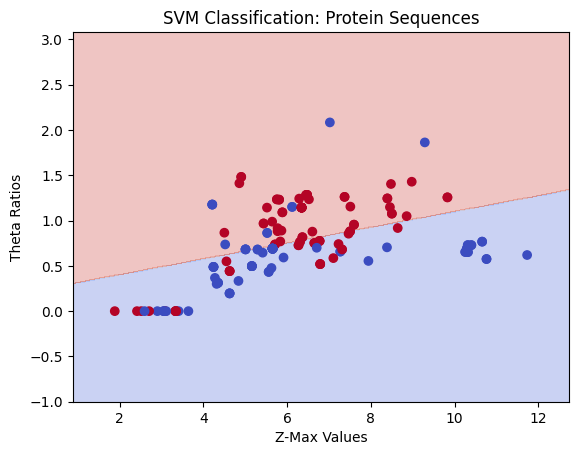

In [ ]:

z_max_values =  np.array(maxScores)
# z_max_values = z_max_values.real
theta_ratios = np.array(thetaRationsMatrix)
# theta_ratios = theta_ratios.real
labels =  np.array(resultRepeatNR)  # 0 for repeating, 1 for non-repeating
X_train, X_test, y_train, y_test = train_test_split(np.column_stack((z_max_values, theta_ratios)), labels, test_size=0.2, random_state=42)

# Create and fit the SVM model
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)
#out_test=model.predict(np.column_stack((theta_ratios,z_max_values)))
#print("Done")
#print(predictions,labels)
# Evaluate the model
new_z_max_values = np.array(testMaxScores)#7.037(R)#7.0239
new_theta_ratios = np.array(testThethaRationMatrix)#2.108(R)#2.3809

#Predict on the new input data
new_predictions = model.predict(np.column_stack((new_z_max_values, new_theta_ratios)))

print("New Data Predictions:", new_predictions)

confusion = confusion_matrix(y_test, predictions)
sensitivity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
specificity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
fMeasure = 2*confusion[0,0] / (confusion[1,0] + confusion[0,1] + 2*confusion[0,0])
mcc = matthews_corrcoef(y_test, predictions)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Matthews Correlation Coefficient:", mcc)
print("F-Measure:", fMeasure)

# Plot the decision boundary
h = 0.01
x_min, x_max = z_max_values.min() - 1, z_max_values.max() + 1
y_min, y_max = theta_ratios.min() - 1, theta_ratios.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Ensure that the number of features in np.c_ matches the number of features used for training
Z = model.predict(np.column_stack((xx.ravel(), yy.ravel())))
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(z_max_values, theta_ratios, c=labels, cmap=plt.cm.coolwarm)
plt.xlabel('Z-Max Values')
plt.ylabel('Theta Ratios')
plt.title('SVM Classification: Protein Sequences')
plt.show()


SVM --rbf Classification

New Data Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 1 1 0]
Sensitivity: 0.8461538461538461
Specificity: 0.7727272727272727
Matthews Correlation Coefficient: 0.6002794251812357
F-Measure: 0.7586206896551724


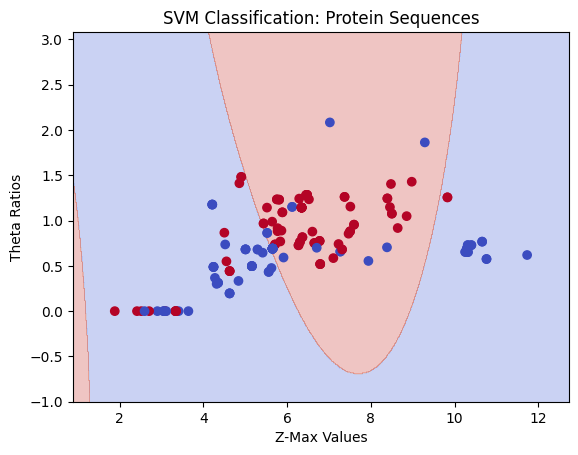

In [ ]:

z_max_values =  np.array(maxScores)
# z_max_values = z_max_values.real
theta_ratios = np.array(thetaRationsMatrix)
# theta_ratios = theta_ratios.real
labels =  np.array(resultRepeatNR)  # 0 for repeating, 1 for non-repeating
X_train, X_test, y_train, y_test = train_test_split(np.column_stack((z_max_values, theta_ratios)), labels, test_size=0.2, random_state=42)

# Create and fit the SVM model
model = svm.SVC(kernel='rbf')
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)
#out_test=model.predict(np.column_stack((theta_ratios,z_max_values)))
#print("Done")
#print(predictions,labels)
# Evaluate the model
new_z_max_values = np.array(testMaxScores)#7.037(R)#7.0239
new_theta_ratios = np.array(testThethaRationMatrix)#2.108(R)#2.3809

#Predict on the new input data
new_predictions = model.predict(np.column_stack((new_z_max_values, new_theta_ratios)))

print("New Data Predictions:", new_predictions)

confusion = confusion_matrix(y_test, predictions)
sensitivity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
specificity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
fMeasure = 2*confusion[0,0] / (confusion[1,0] + confusion[0,1] + 2*confusion[0,0])
mcc = matthews_corrcoef(y_test, predictions)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Matthews Correlation Coefficient:", mcc)
print("F-Measure:", fMeasure)

# Plot the decision boundary
h = 0.01
x_min, x_max = z_max_values.min() - 1, z_max_values.max() + 1
y_min, y_max = theta_ratios.min() - 1, theta_ratios.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Ensure that the number of features in np.c_ matches the number of features used for training
Z = model.predict(np.column_stack((xx.ravel(), yy.ravel())))
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(z_max_values, theta_ratios, c=labels, cmap=plt.cm.coolwarm)
plt.xlabel('Z-Max Values')
plt.ylabel('Theta Ratios')
plt.title('SVM Classification: Protein Sequences')
plt.show()


SVM -- poly Classification

New Data Predictions: [0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0
 1 1 0]
Sensitivity: 1.0
Specificity: 0.8181818181818182
Matthews Correlation Coefficient: 0.7909920664569658
F-Measure: 0.8666666666666667


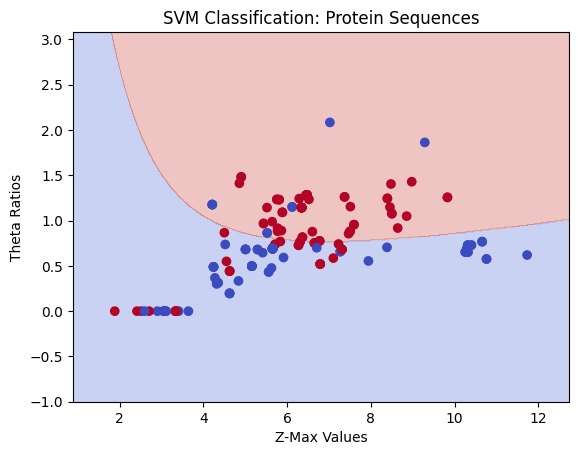

In [ ]:

z_max_values =  np.array(maxScores)
# z_max_values = z_max_values.real
theta_ratios = np.array(thetaRationsMatrix)
# theta_ratios = theta_ratios.real
labels =  np.array(resultRepeatNR)  # 0 for repeating, 1 for non-repeating
X_train, X_test, y_train, y_test = train_test_split(np.column_stack((z_max_values, theta_ratios)), labels, test_size=0.2, random_state=42)

# Create and fit the SVM model
model = svm.SVC(kernel='poly')
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)
#out_test=model.predict(np.column_stack((theta_ratios,z_max_values)))
#print("Done")
#print(predictions,labels)
# Evaluate the model
new_z_max_values = np.array(testMaxScores)#7.037(R)#7.0239
new_theta_ratios = np.array(testThethaRationMatrix)#2.108(R)#2.3809

#Predict on the new input data
new_predictions = model.predict(np.column_stack((new_z_max_values, new_theta_ratios)))

print("New Data Predictions:", new_predictions)

confusion = confusion_matrix(y_test, predictions)
sensitivity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
specificity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
fMeasure = 2*confusion[0,0] / (confusion[1,0] + confusion[0,1] + 2*confusion[0,0])
mcc = matthews_corrcoef(y_test, predictions)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Matthews Correlation Coefficient:", mcc)
print("F-Measure:", fMeasure)

# Plot the decision boundary
h = 0.01
x_min, x_max = z_max_values.min() - 1, z_max_values.max() + 1
y_min, y_max = theta_ratios.min() - 1, theta_ratios.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Ensure that the number of features in np.c_ matches the number of features used for training
Z = model.predict(np.column_stack((xx.ravel(), yy.ravel())))
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(z_max_values, theta_ratios, c=labels, cmap=plt.cm.coolwarm)
plt.xlabel('Z-Max Values')
plt.ylabel('Theta Ratios')
plt.title('SVM Classification: Protein Sequences')
plt.show()


Logistic Regression

<ipython-input-24-5c90be31aa0c>:49: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k', marker='x', label='Testing Data')


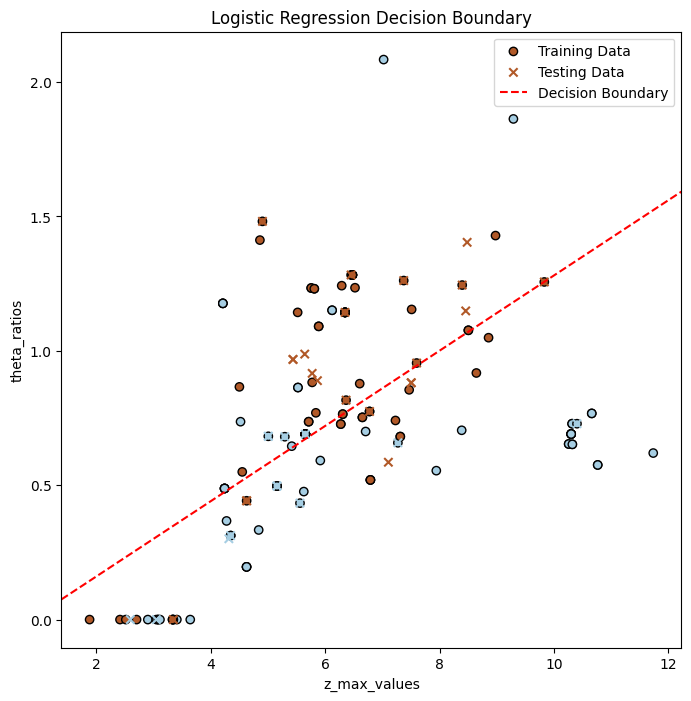

Labels for testing data: [1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0
 1 1 0]
Sensitivity: 0.69
Specificity: 0.64
Matthews Correlation Coefficient: 0.32
F-Measure: 0.6


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, matthews_corrcoef
from sklearn.model_selection import train_test_split

# Provided training data
z_max_values = np.array(maxScores)
theta_ratios = np.array(thetaRationsMatrix)
labels = np.array(resultRepeatNR)

# Combine the first two parameters into a 2D array
X = np.column_stack((z_max_values, theta_ratios))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Provided test data
new_z_max_values = np.array(testMaxScores)
new_theta_ratios = np.array(testThethaRationMatrix)

# Combine the test data into a 2D array
new_data = np.column_stack((new_z_max_values, new_theta_ratios))

# Make predictions for the new data
predictions = model.predict(new_data)

# Evaluate the model on the testing data
accuracy = accuracy_score(y_test, model.predict(X_test))
confusion = confusion_matrix(y_test, model.predict(X_test))
sensitivity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
specificity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
mcc = matthews_corrcoef(y_test, model.predict(X_test))
fMeasure = 2*confusion[0,0] / (confusion[1,0] + confusion[0,1] + 2*confusion[0,0])

# Plot the decision boundary
plt.figure(figsize=(8, 8))

# Plot points for the training data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k', marker='o', label='Training Data')

# Plot points for the testing data
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k', marker='x', label='Testing Data')

# Plot decision boundary
ax = plt.gca()
ax.autoscale(False)
x_vals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
y_vals = -(model.intercept_ + model.coef_[0, 0] * x_vals) / model.coef_[0, 1]
plt.plot(x_vals, y_vals, '--', c='red', label='Decision Boundary')

plt.xlabel('z_max_values')
plt.ylabel('theta_ratios')
plt.title('Logistic Regression Decision Boundary')
plt.legend()
plt.show()

# Print the results
print(f"Labels for testing data: {predictions}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")
print("F-Measure:", fMeasure)


Perceptron

<ipython-input-25-0d428f721167>:48: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k', marker='x', label='Testing Data')


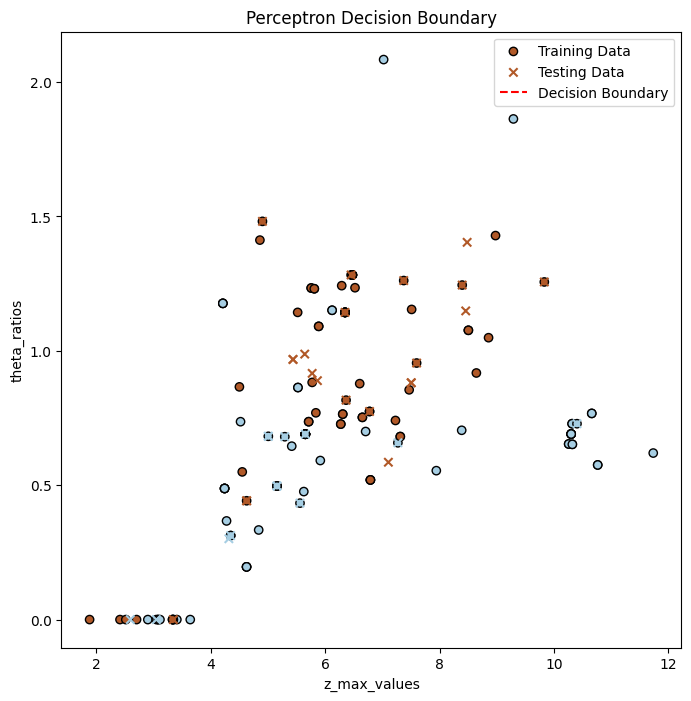

Labels for testing data: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
Sensitivity: 0.00
Specificity: 1.00
Matthews Correlation Coefficient: 0.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import train_test_split

# Provided training data
z_max_values = np.array(maxScores)
theta_ratios = np.array(thetaRationsMatrix)
labels = np.array(resultRepeatNR)

# Combine the first two parameters into a 2D array
X = np.column_stack((z_max_values, theta_ratios))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Create a Perceptron model
model = Perceptron()

# Train the model on the training data
model.fit(X_train, y_train)

# Provided test data
new_z_max_values = np.array(testMaxScores)
new_theta_ratios = np.array(testThethaRationMatrix)

# Combine the test data into a 2D array
new_data = np.column_stack((new_z_max_values, new_theta_ratios))

# Make predictions for the new data
predictions = model.predict(new_data)

# Evaluate the model on the testing data
accuracy = accuracy_score(y_test, model.predict(X_test))
confusion = confusion_matrix(y_test, model.predict(X_test))
sensitivity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
specificity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
mcc = matthews_corrcoef(y_test, model.predict(X_test))

# Plot the decision boundary
plt.figure(figsize=(8, 8))

# Plot points for the training data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k', marker='o', label='Training Data')

# Plot points for the testing data
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k', marker='x', label='Testing Data')

# Plot decision boundary
ax = plt.gca()
ax.autoscale(False)
x_vals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
y_vals = -(model.intercept_ + model.coef_[0, 0] * x_vals) / model.coef_[0, 1]
plt.plot(x_vals, y_vals, '--', c='red', label='Decision Boundary')

plt.xlabel('z_max_values')
plt.ylabel('theta_ratios')
plt.title('Perceptron Decision Boundary')
plt.legend()
plt.show()

# Print the results
print(f"Labels for testing data: {predictions}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")


Naves Bayes


<ipython-input-26-8857668428a7>:57: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k', marker='x', label='Testing Data')


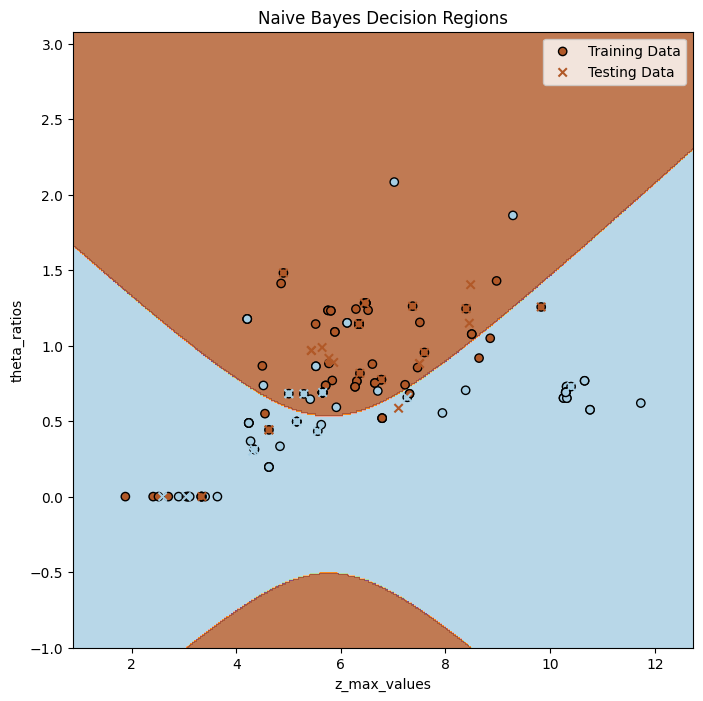

Labels for testing data: [1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 0 0
 1 1 0]
Sensitivity: 0.69
Specificity: 0.77
Matthews Correlation Coefficient: 0.46


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import train_test_split

# Provided training data
z_max_values = np.array(maxScores)
theta_ratios = np.array(thetaRationsMatrix)
labels = np.array(resultRepeatNR)

# Combine the first two parameters into a 2D array
X = np.column_stack((z_max_values, theta_ratios))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Create a Gaussian Naive Bayes model
model = GaussianNB()

# Train the model on the training data
model.fit(X_train, y_train)

# Provided test data
new_z_max_values = np.array(testMaxScores)
new_theta_ratios = np.array(testThethaRationMatrix)

# Combine the test data into a 2D array
new_data = np.column_stack((new_z_max_values, new_theta_ratios))

# Make predictions for the new data
predictions = model.predict(new_data)

# Evaluate the model on the testing data
accuracy = accuracy_score(y_test, model.predict(X_test))
confusion = confusion_matrix(y_test, model.predict(X_test))
sensitivity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])
specificity = confusion[1, 1] / (confusion[1, 0] + confusion[1, 1])
mcc = matthews_corrcoef(y_test, model.predict(X_test))

# Plot the decision regions
plt.figure(figsize=(8, 8))

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

# Plot points for the training data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k', marker='o', label='Training Data')

# Plot points for the testing data
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k', marker='x', label='Testing Data')

plt.xlabel('z_max_values')
plt.ylabel('theta_ratios')
plt.title('Naive Bayes Decision Regions')
plt.legend()
plt.show()

# Print the results
print(f"Labels for testing data: {predictions}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Matthews Correlation Coefficient: {mcc:.2f}")
